# WGAN-GP 
## As a part of conditional GAN



### Citation

The training part is from:

François Chollet (2020) The most modern way to implement a WGAN-GP in Keras https://github.com/keras-team/keras-io/blob/master/examples/generative/wgan_gp.py

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pwd

/content


In [ ]:
%cd sample_data
!cp -avr '/content/drive/My Drive/LDCT.zip' '/content/sample_data/'
!unzip LDCT.zip

/content/sample_data
'/content/drive/My Drive/LDCT.zip' -> '/content/sample_data/LDCT.zip'
Archive:  LDCT.zip
   creating: LDCT/
   creating: LDCT/N204/
  inflating: LDCT/N204/.DS_Store     
   creating: __MACOSX/
   creating: __MACOSX/LDCT/
   creating: __MACOSX/LDCT/N204/
  inflating: __MACOSX/LDCT/N204/._.DS_Store  
   creating: LDCT/N204/09-02-2018-56942/
  inflating: LDCT/N204/09-02-2018-56942/.DS_Store  
   creating: __MACOSX/LDCT/N204/09-02-2018-56942/
  inflating: __MACOSX/LDCT/N204/09-02-2018-56942/._.DS_Store  
   creating: LDCT/N204/09-02-2018-56942/1.000000-Full dose images-15218/
  inflating: LDCT/N204/09-02-2018-56942/1.000000-Full dose images-15218/1-21.dcm  
   creating: __MACOSX/LDCT/N204/09-02-2018-56942/1.000000-Full dose images-15218/
  inflating: __MACOSX/LDCT/N204/09-02-2018-56942/1.000000-Full dose images-15218/._1-21.dcm  
  inflating: LDCT/N204/09-02-2018-56942/1.000000-Full dose images-15218/1-09.dcm  
  inflating: __MACOSX/LDCT/N204/09-02-2018-56942/1.000000-

In [ ]:
import os
import shutil
directory_list = []

for item in os.listdir("/content/sample_data/LDCT"):
    directory_list.append(item)
sorted_files = sorted(directory_list)

print(sorted_files)

['.DS_Store', 'C111', 'L125', 'L145', 'N001', 'N139', 'N140', 'N153', 'N160', 'N169', 'N180', 'N181', 'N204']


In [ ]:
sorted_files = sorted_files[1:]

In [ ]:
sorted_files

['C111',
 'L125',
 'L145',
 'N001',
 'N139',
 'N140',
 'N153',
 'N160',
 'N169',
 'N180',
 'N181',
 'N204']

In [ ]:
for folder in sorted_files:
    outer_path = "/content/sample_data/LDCT/"+folder+"/"
    for sub in os.listdir(outer_path):
        inner_path = sub +"/*"
        if sub == ".DS_Store":
            pass
        elif sub == ".ipynb_checkpoints":
            pass
        else:
            os.system("mv  -v "+outer_path+inner_path+" "+outer_path)
            os.system("mv "+outer_path+"*Full* "+outer_path+"full_dose")
            os.system("mv "+outer_path+"*Low* "+outer_path+"low_dose")
            shutil.rmtree(os.path.join(outer_path,sub))

In [ ]:
!pip install pydicom

     |████████████████████████████████| 1.9MB 13.2MB/s 


### Start from this line
***

In [1]:
import pydicom as dicom
import os

def load_path(path):
    directories_low = []
    directories_full = []
    directory_list = os.listdir(path)
    directory_list = sorted(directory_list)
    for i in directory_list:
        if os.path.isdir(os.path.join(path,i)):
            path_image = os.path.join(path,i)
            path_full = os.path.join(path_image,"full_dose")
            path_low = os.path.join(path_image,"low_dose")
            directories_full.append(path_full)
            directories_low.append(path_low)
    return directories_full, directories_low

In [2]:
def load_data_from_dirs(dirs):
    files = []
    file_names = []
    for d in dirs:
        for f in os.listdir(d): 
            if f.endswith('dcm'):
                file_name = os.path.join(d,f)
                ds = dicom.dcmread(file_name)
                image = ds.pixel_array
                files.append(image)
                #file_names.append(os.path.join(d,f))     
    return files

In [3]:
directories_full, directories_low = load_path("/content/sample_data/LDCT")

In [4]:
fr_filename_train = load_data_from_dirs(directories_full)
lr_filename_train = load_data_from_dirs(directories_low)

In [5]:
import numpy as np
lr_train = np.array(lr_filename_train)
fr_train = np.array(fr_filename_train)

In [6]:
lr_train = lr_train.reshape((lr_train.shape[0], lr_train.shape[1],lr_train.shape[2], 1))
fr_train = fr_train.reshape((fr_train.shape[0], fr_train.shape[1],fr_train.shape[2], 1))

In [7]:
import tensorflow as tf

def crop_image(example):
    img = example['hr']
    img1 = example['lr']
    hr_patch = tf.image.central_crop(img,0.5)
    lr_patch = tf.image.central_crop(img1,0.5)
    hr_patch = tf.cast(hr_patch, tf.float32) / (255. / 2.)
    lr_patch = tf.cast(lr_patch, tf.float32) / (255. / 2.)
    #lr_patch = tf.image.resize(hr_patch, size=[96, 96])
    return lr_patch, hr_patch

In [8]:
train_data = tf.data.Dataset.from_tensor_slices({'lr': lr_train,'hr': fr_train})

In [9]:
train_dataset = train_data.map(crop_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache()

In [10]:
train_dataset = train_dataset.batch(9).repeat()

In [11]:
from tensorflow.keras.applications.vgg19 import VGG19
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from numpy.random import randint
from tqdm import tqdm
import matplotlib.pyplot as plt

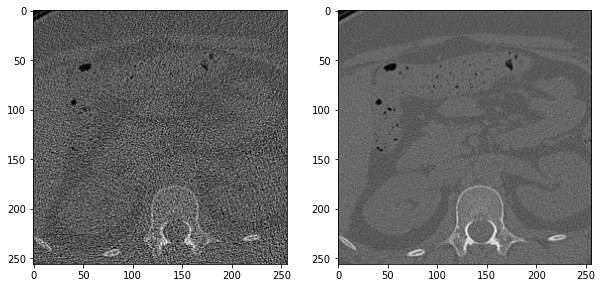

In [12]:
cropped_img_iter = iter(train_dataset)
val_cropped_img = next(cropped_img_iter)
fig, axes = plt.subplots(1,2, figsize=(10,10))
axes[0].imshow(tf.squeeze(val_cropped_img[0][0]),cmap='gray')
axes[1].imshow(tf.squeeze(val_cropped_img[1][0]),cmap='gray')

In [13]:
inputs = tf.keras.Input(shape=(256, 256, 1)) # Model to 2x the image
x = inputs
x = tf.keras.layers.Conv2D(64, 9, padding='same')(x)
x = tf.keras.layers.PReLU()(x)
c1 = x

x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.PReLU()(x)
x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Add()([c1, x])
c2 = x

x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.PReLU()(x)
x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Add()([c2, x])
c3 = x

x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.PReLU()(x)
x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Add()([c3, x])
c4 = x

x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.PReLU()(x)
x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Add()([c4, x])
c5 = x

x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.PReLU()(x)
x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Add()([c5, x])
c6 = x

x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Add()([c1, x])

x = tf.keras.layers.Conv2D(256, 3, padding='same')(x)
#x = tf.keras.layers.Lambda(lambda x: tf.nn.depth_to_space(x, 2))(x)
x = tf.keras.layers.PReLU()(x)

x = tf.keras.layers.Conv2D(256, 3, padding='same')(x)
#x = tf.keras.layers.Lambda(lambda x: tf.nn.depth_to_space(x, 2))(x)
x = tf.keras.layers.PReLU()(x)

x = tf.keras.layers.Conv2D(1, 9, padding='same')(x)
output = x
model = tf.keras.Model(inputs, output)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 5248        input_1[0][0]                    
__________________________________________________________________________________________________
p_re_lu (PReLU)                 (None, 256, 256, 64) 4194304     conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       p_re_lu[0][0]                    
_______________________________________________________________________________________

In [14]:
inputs_d = tf.keras.Input(shape=(256, 256, 1)) # Discriminator Model
x_d = inputs_d
x_d = tf.keras.layers.Conv2D(64, 3, strides=2, padding='same')(x_d)
x_d = tf.keras.layers.LeakyReLU(alpha=0.1)(x_d)

x_d = tf.keras.layers.Conv2D(64, 3, strides=2, padding='same')(x_d)
x_d = tf.keras.layers.LayerNormalization()(x_d)
x_d = tf.keras.layers.LeakyReLU(alpha=0.1)(x_d)



x_d = tf.keras.layers.Conv2D(128, 3, strides=1, padding='same')(x_d)
x_d = tf.keras.layers.LayerNormalization()(x_d)
x_d = tf.keras.layers.LeakyReLU(alpha=0.1)(x_d)

x_d = tf.keras.layers.Conv2D(128, 3, strides=2, padding='same')(x_d)
x_d = tf.keras.layers.LayerNormalization()(x_d)
x_d = tf.keras.layers.LeakyReLU(alpha=0.1)(x_d)

x_d = tf.keras.layers.Conv2D(256, 3, strides=1, padding='same')(x_d)
x_d = tf.keras.layers.LayerNormalization()(x_d)
x_d = tf.keras.layers.LeakyReLU(alpha=0.1)(x_d)

x_d = tf.keras.layers.Conv2D(256, 3, strides=2, padding='same')(x_d)
x_d = tf.keras.layers.LayerNormalization()(x_d)
x_d = tf.keras.layers.LeakyReLU(alpha=0.1)(x_d)

x_d = tf.keras.layers.Conv2D(512, 3, strides=1, padding='same')(x_d)
x_d = tf.keras.layers.LayerNormalization()(x_d)
x_d = tf.keras.layers.LeakyReLU(alpha=0.1)(x_d)

x_d = tf.keras.layers.Conv2D(512, 3, strides=2, padding='same')(x_d)
x_d = tf.keras.layers.LayerNormalization()(x_d)
x_d = tf.keras.layers.LeakyReLU(alpha=0.1)(x_d)

x_d = tf.keras.layers.Flatten()(x_d)
x_d = tf.keras.layers.Dense(1024)(x_d)
x_d = tf.keras.layers.LeakyReLU(alpha=0.1)(x_d)
x_d = tf.keras.layers.Dense(1, activation='sigmoid')(x_d)
output_d = x_d
model_d = tf.keras.Model(inputs_d, output_d)
model_d.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 128, 128, 64)      640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
layer_normalization (LayerNo (None, 64, 64, 64)        128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 64, 64, 128)      

In [15]:
class GAN(tf.keras.Model):
  def __init__(self, discriminator, generator):
    super(GAN, self).__init__()
    self.discriminator = discriminator
    self.generator = generator
    global d_loss_list
    global g_loss_list
    global recon_loss_list



  def compile(self, 
              d_optimizer, 
              g_optimizer, 
              loss_fn, 
              recon_loss_fn, 
              loss_weights=[1,1,1]):
    super(GAN, self).compile()
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.loss_fn = loss_fn
    self.recon_loss_fn = recon_loss_fn
    self.loss_weights = loss_weights

  def gradient_penalty(self,batch_size, real_images, fake_images):
    alpha = tf.random.uniform(shape=[batch_size, 1, 1, 1], minval=0., maxval=1.)
    differences = fake_images - real_images
    interpolates = real_images + (alpha * differences)
    gradients = tf.gradients(self.discriminator(interpolates, training=True), [interpolates])[0]
    slopes = tf.sqrt(1e-5+tf.reduce_sum(tf.square(gradients), axis=[1, 2, 3]))
    gradient_penalty = tf.reduce_mean((slopes-1.)**2)
    return gradient_penalty

  def train_step(self, data):
    input_images, real_images = data  #? what is the type of data, and it's shape
    batch_size = tf.shape(real_images)[0] # 
    #print(batch_size)
    generated_images = self.generator(input_images)
    combined_images = tf.concat([generated_images, real_images], axis=0)
    labels = tf.concat([tf.ones((batch_size, 1)),
                        -tf.ones((batch_size, 1))], axis=0)
    labels += 0.05 * tf.random.uniform(tf.shape(labels))
    #print(tf.shape(combined_images))
    with tf.GradientTape() as tape:
      noise_concat = tf.concat([tf.random.normal(shape=tf.shape(generated_images), mean=0.0, stddev=0.2, dtype=tf.float32),
                                tf.zeros(shape=tf.shape(real_images))], axis=0)
      noisy_image =combined_images + noise_concat
      predictions = self.discriminator(noisy_image)
      d_loss = self.loss_fn(labels, predictions)
      rl_img, fk_img = tf.split(noisy_image, num_or_size_splits=2, axis=0)
      gp = self.gradient_penalty(batch_size, rl_img, fk_img)
      d_loss =d_loss*self.loss_weights[0] + gp*10
    grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
    self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

    with tf.GradientTape() as tape:
      generated_images = self.generator(input_images)
      predictions = self.discriminator(generated_images)
      g_loss = self.loss_fn(-tf.ones((batch_size, 1)), predictions)
      recon_loss = self.recon_loss_fn(real_images, generated_images)
      loss = g_loss*self.loss_weights[1] + recon_loss*self.loss_weights[2]
    grads = tape.gradient(loss, self.generator.trainable_weights)
    self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
    psnr = tf.image.psnr(generated_images, real_images, max_val=2.0)
    ssim = tf.image.ssim(generated_images, real_images, max_val=2.0, filter_size=11,filter_sigma=1.5, k1=0.01, k2=0.03)
    return { 'd_loss': d_loss, 'g_loss': g_loss, 'recon_loss': recon_loss, 'PSNR':psnr, 'SSIM':ssim}

gan_model = GAN(model_d, model)
gan_model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001), 
                  tf.keras.optimizers.Adam(learning_rate=0.0001), 
                  lambda y,x: tf.reduce_mean(tf.keras.losses.binary_crossentropy(y,x)), 
                  lambda y,x: tf.reduce_mean(tf.keras.losses.mean_squared_error(y,x)),
                  loss_weights=[1,10, 1])

In [25]:
loss_hist = gan_model.fit(train_dataset, steps_per_epoch=50, epochs=10)

Epoch 1/10
50/50 [==============================] - 32s 632ms/step - d_loss: 10.0561 - g_loss: -3.7844 - recon_loss: 0.4069 - PSNR: 11.1565 - SSIM: 0.3763
Epoch 2/10
50/50 [==============================] - 32s 633ms/step - d_loss: 10.0516 - g_loss: -3.7117 - recon_loss: 0.0823 - PSNR: 17.5695 - SSIM: 0.5410
Epoch 3/10
50/50 [==============================] - 32s 634ms/step - d_loss: 10.0532 - g_loss: -3.7291 - recon_loss: 0.3965 - PSNR: 11.2681 - SSIM: 0.3819
Epoch 4/10
50/50 [==============================] - 32s 634ms/step - d_loss: 10.0467 - g_loss: -3.6842 - recon_loss: 0.0945 - PSNR: 17.2252 - SSIM: 0.5421
Epoch 5/10
50/50 [==============================] - 32s 635ms/step - d_loss: 10.0600 - g_loss: -3.6275 - recon_loss: 0.3977 - PSNR: 11.2599 - SSIM: 0.3843
Epoch 6/10
50/50 [==============================] - 32s 636ms/step - d_loss: 10.0449 - g_loss: -3.6820 - recon_loss: 0.0811 - PSNR: 17.5633 - SSIM: 0.5389
Epoch 7/10
50/50 [==============================] - 32s 635ms/step - d

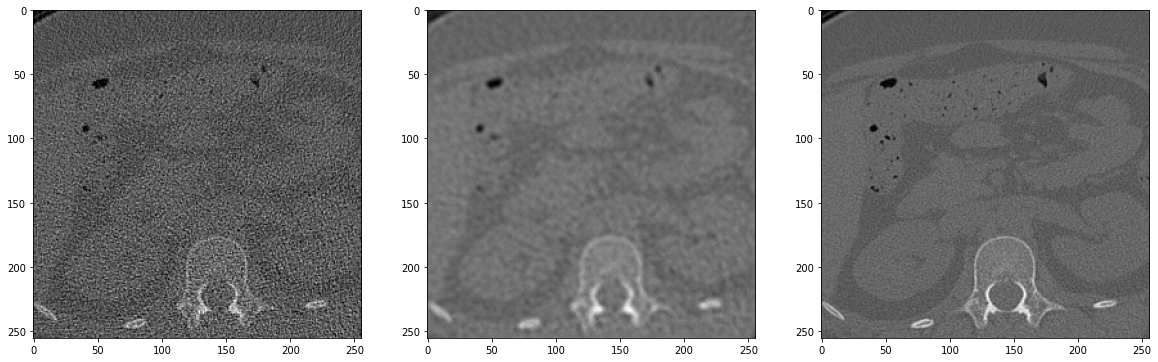

In [24]:
fakes = model.predict(val_cropped_img[0])
fig, axes = plt.subplots(1,3, figsize=(20,20))
ds = np.squeeze(val_cropped_img[0][0].numpy())
us = np.squeeze(fakes[0])
ori = np.squeeze(val_cropped_img[1][0])
ds = (ds - ds.min()) / (ds.max() - ds.min())
us = (us - us.min()) / (us.max() - us.min())
ori = (ori - ori.min()) / (ori.max() - ori.min())
axes[0].imshow(ds,cmap='gray')
axes[1].imshow(us,cmap='gray')
axes[2].imshow(ori,cmap='gray')